<a href="https://colab.research.google.com/github/soutrik71/pytorch_classics/blob/main/APTorch4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Next series of notebook s will be all about discussion on
0. Basics of Embedding Model
1. Primary setup of Rnn architecture
2. Experiment with RNN on a few text based use cases
3. Primary setup of LSTM/GRU architecture
4. Experiment with LSTM/GRU on a few text based use cases
5. Embeddings and its different forms of experimentations
6. Experiment with pre-trained embedding models on a few text based use cases
7. Torchtext library and major functionalities

## BOOK1 -Word Embeddings Z2H

In [16]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [17]:
!pip install portalocker
!pip install torchview
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.0 MB/s eta 0:00:00


In [89]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
from torch.utils.data import DataLoader
from torchtext import data
from torchtext import datasets
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import re
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset
from torchsummary import summary
from torchview import draw_graph
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from torcheval.metrics import MulticlassAccuracy,BinaryAccuracy
import torch.optim as optim

In [21]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [32]:
# Set manual seed since nn.Parameter are randomly initialzied
set_seed(42)
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 1024
epochs = 10
lr = 1e-3

Random seed set as 42
cpu


In [98]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, labels, colors,
                       loss_legend_loc='upper center', acc_legend_loc='upper left', legend_font=5,
                       fig_size=(16, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):

    plt.rcParams["figure.figsize"] = fig_size
    plt.figure


    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])

    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))

        min_train_loss = np.array(train_loss[i]).min()

        min_val_loss = np.array(val_loss[i]).min()

        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(min_train_loss, labels[i]))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(min_val_loss, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Loss')

    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])

    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))

        max_train_acc = np.array(train_acc[i]).max()

        max_val_acc = np.array(val_acc[i]).max()

        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(max_train_acc, labels[i]))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(max_val_acc, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Accuracy')

    plt.show()


#### Dataset Preparation
In order to prepare the dataset, we have loaded the dataset, populated vocabulary with the words of text documents, and then created data loaders that will map words to their indexes according to vocabulary. Later on, when we give this list of word indexes (according to vocabulary) as input to the network, the embedding layer will map indexes to their respective embeddings.

In [33]:
# get train and testset
train_dataset, test_dataset  = datasets.AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [34]:
# view data
train_iter = iter(datasets.AG_NEWS(split="train").shuffle()) # only training instances

In [35]:
next(train_iter) # (label,text in the form of a tuples)

(1,
 'N. Korea calls Bush  quot;human trash quot; North Korea has hurled invective at US President George W. Bush for a second day, calling him a political idiot and human trash, and has said six-party talks on Pyongyang #39;s nuclear ambitions appear doomed.')

It has text documents for 4 different categories (["World", "Sports", "Business", "Sci/Tech"]) and label index starts form 0

#### Tokenize Text Data And Build Vocabulary
get_tokenizer() - a simple tokenizer that separates words from the sentence. It takes text as input and returns a list of tokens/words as output.
build_vocab_from_iterator() -generates a vocabulary mapping words to their indexes by iterating over datasets and their text documents, tokenizing them with a custom tokenizer function.

In [36]:
def tokenizer(inp_str):
  """Returns list of words from the paragraph"""
  re.findall(r'\w+',inp_str)

# we wil use advanced tokenizer provided by torch
tokenizer = get_tokenizer("basic_english")
print(tokenizer("You can now install TorchText using pip!"))

['you', 'can', 'now', 'install', 'torchtext', 'using', 'pip', '!']


In [37]:
def build_vocab_iter(datasets):
  """yields tokenized text """
  for dataset in datasets:
    for _, text in dataset:
      yield tokenizer(text)

vocab = build_vocab_from_iterator(build_vocab_iter([train_dataset, test_dataset]), specials=["<unk>"]) # build vocab from an iterator
vocab.set_default_index(vocab["<unk>"]) # anything unk will be have a default index

In [38]:
sample = 'LA parking company lands contract renewal with ABIA Los Angeles-based Ampco System Parking has received a multi-year contract renewal with Austin-Bergstrom International Airport. '
tokenized_sample = tokenizer(sample)
print(tokenized_sample)
print(vocab(tokenized_sample))

['la', 'parking', 'company', 'lands', 'contract', 'renewal', 'with', 'abia', 'los', 'angeles-based', 'ampco', 'system', 'parking', 'has', 'received', 'a', 'multi-year', 'contract', 'renewal', 'with', 'austin-bergstrom', 'international', 'airport', '.']
[1747, 9585, 54, 4105, 424, 11934, 18, 60124, 580, 26155, 61237, 265, 9585, 28, 1192, 5, 9144, 424, 11934, 18, 62573, 139, 1174, 1]


The tokenizer is initialized using the "basic_english" tokenizer from torchtext.data.utils. dataset is loaded into training, validation, and testing iterators. The yield_tokens function tokenizes text iteratively, allowing efficient processing of large datasets by avoiding memory overload. The vocabulary is constructed from the iterator with a special token for unknown words, along with a default index for unknown words.

#### Dataloader
Train and test data loaders are created for data traversal during training. A helper function tokenizes and vectorizes text documents, limiting each document to a maximum of 50 words. It pads documents with fewer words and truncates those exceeding the limit. Target labels are mapped to [0,3] from [1,4], with a batch size of 1024, resulting in data of shape [1024,50] per batch with 1024 target labels for categories ["World", "Sports", "Business", "Sci/Tech"].
The data is passed through dataloader and ready for modelling

In [49]:
def vectorize_batch(batch):
  """Vectorize the batch"""
  Y,X  = list(zip(*batch))
  X=[vocab(tokenizer(sample)) for sample in X]
  X = [sample+([0]* (50-len(sample))) if len(sample)<50 else sample[:50] for sample in X] ## Bringing all samples to 50 length ie standardization of length
  Y = [0 if y==0 else y-1 for y in Y] # converting label starting form 0
  return torch.tensor(X, dtype=torch.int64).to(device), torch.tensor(Y, dtype=torch.int64).to(device)

In [50]:
target_classes = ["World", "Sports", "Business", "Sci/Tech"]

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=vectorize_batch)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, collate_fn=vectorize_batch)

In [51]:
for X, Y in train_loader:
    print(X.shape, Y.shape)
    break

torch.Size([1024, 50]) torch.Size([1024])


#### Basic Word Embedding Model

Neural network architecture: Embedding layer maps each word to 25 embeddings, followed by flattening. First linear layer: 1250 input units, 128 output units with ReLU activation. Second linear layer: 128 input units, 64 output units with ReLU activation. Third linear layer: 64 input units, 4 output units (number of target classes/labels).

In [78]:
class BasicEmbeddingClassifier(nn.Module):
  """Basic Embedding Classifier"""
  def __init__(self, num_classes):
    super(BasicEmbeddingClassifier, self).__init__()

    self.embedding_layer = nn.Sequential(
        nn.Embedding(num_embeddings=98635, embedding_dim=25),
        nn.Flatten(),
        nn.Linear(1250, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, num_classes)
    )

  def forward(self, x):
    return self.embedding_layer(x)

In [94]:
basic_embedder = BasicEmbeddingClassifier(4).to(device)
print(basic_embedder)

BasicEmbeddingClassifier(
  (embedding_layer): Sequential(
    (0): Embedding(98635, 25)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=1250, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=4, bias=True)
  )
)


In [80]:
# summary(basic_embedder, input_size=[(1024,50)], device='cpu')

In [81]:
# # graphical representation of the model architecture
# model_graph = draw_graph(basic_embedder, input_size=(1,1024,50), expand_nested=True)
# model_graph.resize_graph(scale=10)
# model_graph.visual_graph

In [87]:
def train_module(model:torch.nn.Module,
                 device:torch.device,
                 train_dataloader:torch.utils.data.DataLoader ,
                 optimizer:torch.optim.Optimizer,
                 criterion:torch.nn.Module,
                 metric,
                 train_losses:list,
                 train_metrics:list):

  # setting model to train mode
  model.train()
  pbar = tqdm(train_dataloader)

  # batch metrics
  train_loss = 0
  train_metric = 0
  processed_batch = 0

  for idx, (data,label) in enumerate(pbar):
    # setting up device
    data = data.to(device)
    label = label.to(device)

    # forward pass output
    preds = model(data)

    # calc loss
    loss = criterion(preds, label)
    train_loss += loss.item()
    # print(f"training loss for batch {idx} is {loss}")

    # backpropagation
    optimizer.zero_grad() # flush out  existing grads
    loss.backward() # back prop of weights wrt loss
    optimizer.step() # optimizer step -> minima

    # metric calc
    preds = torch.argmax(preds,dim=1)
    # print(f"preds:: {preds}")
    metric.update(preds,label)
    train_metric += metric.compute().detach().item()

    #updating batch count
    processed_batch += 1

    pbar.set_description(f"Avg Train Loss: {train_loss/processed_batch} Avg Train Metric: {train_metric/processed_batch}")

  # It's typically called after the epoch completes
  metric.reset()
  # updating epoch metrics
  train_losses.append(train_loss/processed_batch)
  train_metrics.append(train_metric/processed_batch)

  return train_losses, train_metrics


In [88]:
def test_module(model:torch.nn.Module,
                device:torch.device,
                test_dataloader:torch.utils.data.DataLoader,
                criterion:torch.nn.Module,
                metric,
                test_losses,
                test_metrics):
  # setting model to eval mode
  model.eval()
  pbar = tqdm(test_dataloader)

  # batch metrics
  test_loss = 0
  test_metric = 0
  processed_batch = 0

  with torch.inference_mode():
    for idx, (data,label) in enumerate(pbar):
      data , label = data.to(device), label.to(device)
      # predictions
      preds = model(data)
      # print(preds.shape)
      # print(label.shape)

      #loss calc
      loss = criterion(preds, label)
      test_loss += loss.item()

      # metric calc
      preds = torch.argmax(preds,dim=1)
      metric.update(preds,label)
      test_metric += metric.compute().detach().item()

      #updating batch count
      processed_batch += 1

      pbar.set_description(f"Avg Test Loss: {test_loss/processed_batch} Avg Test Metric: {test_metric/processed_batch}")

    # It's typically called after the epoch completes
    metric.reset()
    # updating epoch metrics
    test_losses.append(test_loss/processed_batch)
    test_metrics.append(test_metric/processed_batch)

  return test_losses, test_metrics

In [95]:
# driver setup
optimizer = optim.Adam(basic_embedder.parameters(), lr=lr, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
metric = MulticlassAccuracy(device = device, num_classes=10)

In [96]:
# Place holders----
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(basic_embedder, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(basic_embedder, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


Avg Train Loss: 1.2798874610561435 Avg Train Metric: 0.3489892036985543: 100%|██████████| 118/118 [00:08<00:00, 13.52it/s]
Avg Test Loss: 1.2042866051197052 Avg Test Metric: 0.46928707510232925: 100%|██████████| 8/8 [00:00<00:00, 20.50it/s]


Epoch 1


Avg Train Loss: 1.1403992519540302 Avg Train Metric: 0.4877153864856494: 100%|██████████| 118/118 [00:09<00:00, 13.02it/s]
Avg Test Loss: 1.131031945347786 Avg Test Metric: 0.5133157670497894: 100%|██████████| 8/8 [00:00<00:00, 19.71it/s]


Epoch 2


Avg Train Loss: 1.0320543904425734 Avg Train Metric: 0.5521047297170607: 100%|██████████| 118/118 [00:08<00:00, 13.73it/s]
Avg Test Loss: 1.0640948563814163 Avg Test Metric: 0.5474351197481155: 100%|██████████| 8/8 [00:00<00:00, 19.68it/s]


Epoch 3


Avg Train Loss: 0.9162842479802794 Avg Train Metric: 0.6111194870229495: 100%|██████████| 118/118 [00:08<00:00, 13.46it/s]
Avg Test Loss: 1.0080533176660538 Avg Test Metric: 0.5819939002394676: 100%|██████████| 8/8 [00:00<00:00, 19.54it/s]


Epoch 4


Avg Train Loss: 0.8019839742426145 Avg Train Metric: 0.6672381864765943: 100%|██████████| 118/118 [00:09<00:00, 12.59it/s]
Avg Test Loss: 0.9577154517173767 Avg Test Metric: 0.6160972267389297: 100%|██████████| 8/8 [00:00<00:00, 17.34it/s]


Epoch 5


Avg Train Loss: 0.6962371877694534 Avg Train Metric: 0.7188442521176096: 100%|██████████| 118/118 [00:09<00:00, 12.83it/s]
Avg Test Loss: 0.9148283079266548 Avg Test Metric: 0.637284405529499: 100%|██████████| 8/8 [00:00<00:00, 18.49it/s]


Epoch 6


Avg Train Loss: 0.6020460805650485 Avg Train Metric: 0.7631769801600504: 100%|██████████| 118/118 [00:08<00:00, 13.54it/s]
Avg Test Loss: 0.897970400750637 Avg Test Metric: 0.6568443030118942: 100%|██████████| 8/8 [00:00<00:00, 20.46it/s]


Epoch 7


Avg Train Loss: 0.5214188674748954 Avg Train Metric: 0.8004788867497848: 100%|██████████| 118/118 [00:08<00:00, 13.62it/s]
Avg Test Loss: 0.8871237486600876 Avg Test Metric: 0.6724418252706528: 100%|██████████| 8/8 [00:00<00:00, 20.31it/s]


Epoch 8


Avg Train Loss: 0.4531741046930774 Avg Train Metric: 0.8290696255231308: 100%|██████████| 118/118 [00:08<00:00, 13.73it/s]
Avg Test Loss: 0.8781672343611717 Avg Test Metric: 0.6811115592718124: 100%|██████████| 8/8 [00:00<00:00, 19.94it/s]


Epoch 9


Avg Train Loss: 0.3992005813929994 Avg Train Metric: 0.8512050994371964: 100%|██████████| 118/118 [00:08<00:00, 13.75it/s]
Avg Test Loss: 0.8633472323417664 Avg Test Metric: 0.6927149295806885: 100%|██████████| 8/8 [00:00<00:00, 20.27it/s]


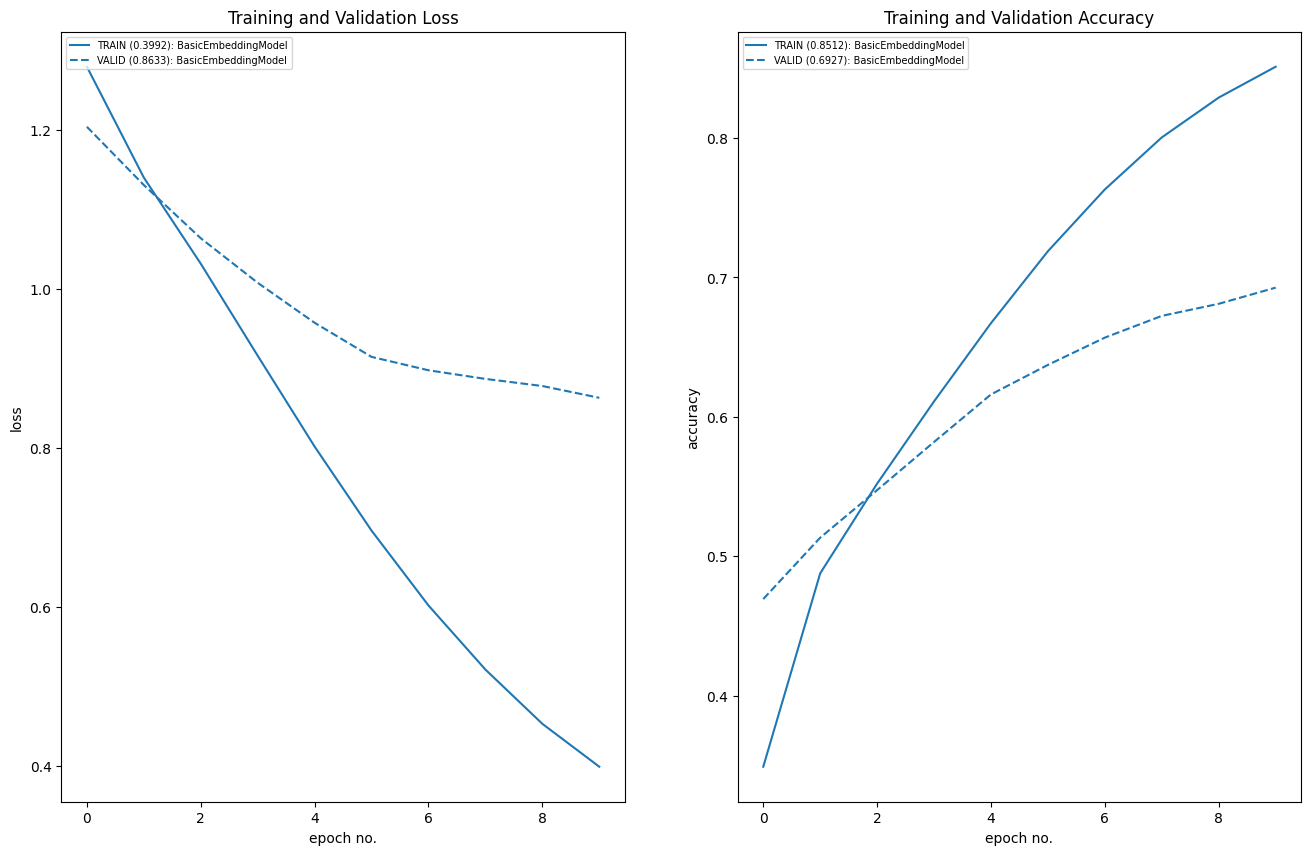

In [101]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['BasicEmbeddingModel'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

Evaluate Network Performance

In [103]:
def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)

    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)
    return Y_shuffled.detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().numpy()

Y_actual, Y_preds = MakePredictions(basic_embedder, test_loader)

In [104]:
print(Y_actual.shape)
print(Y_preds.shape)

(7600,)
(7600,)


7600
